# Proyecto de Ciencia de datos
**Proyecto**: Modelos Predictivos para la Estimación de Ventas de un Hotel
Resort en un Contexto de Crisis Económica       
**Estudiante**: Favio Rafael Guerra Calle                                                 
**Carrera**: Lic.Ingenieria Informatica


## **Fase 1**: Comprension del Negocio

Realizar predicciones de desempeño a futuro de las ventas de un hotel resort en un contexto de crisis económica, mediante el uso de modelos predictivos con el fin de apoyar la toma de decisiones estratégicas y evaluar la viabilidad del negocio.


## **Fase 2**: Comprension de los Datos

 **Hotel Resort**

Importacion de librerias inicial

In [7]:
!pip install keras-tuner

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from kerastuner.tuners import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner.engine.hyperparameters import HyperParameters

C:\Users\Farzor\AppData\Local\Temp\ipykernel_1104\1724280388.py:12: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


Carga de datos

In [10]:
df = pd.read_excel(r"../Data_Source/HotelResort.xlsx")

In [11]:
print(df.columns)

Index(['Fecha Actual', 'Fecha de ingreso', 'Razon social',
       'Nombre del cliente', 'PAQUETE', 'TIEMPO DE ESTADIA', 'TOTAL FACTURA',
       'IMPORTE PAGADO', 'SALDO POR COBRAR', 'EJECUTIVO', 'OBSERVACIONES'],
      dtype='object')


In [12]:
df = df.rename(columns={'Fecha Actual': 'Fecha', 'TOTAL FACTURA': 'TotalFactura'})

In [13]:
df = df[['Fecha', 'TotalFactura']]

Convierte a formato fecha

In [15]:
df['Fecha'] = pd.to_datetime(df['Fecha'], errors='coerce')
df['TotalFactura'] = pd.to_numeric(df['TotalFactura'], errors='coerce')

Elimina filas con valores nulos

In [17]:
print(df.isnull().sum())
df.dropna(subset=['Fecha', 'TotalFactura'], inplace=True)

Fecha           15
TotalFactura     4
dtype: int64


Media, mediana, desviación estándar

In [19]:
print(df['TotalFactura'].describe())

count     2037.000000
mean       830.714674
std       1336.475848
min          0.000000
25%        258.000000
50%        490.000000
75%       1000.000000
max      40341.500000
Name: TotalFactura, dtype: float64


In [20]:
df.count()

Fecha           2037
TotalFactura    2037
dtype: int64

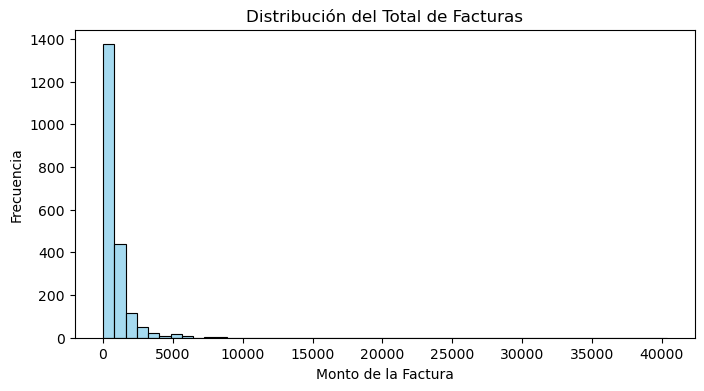

In [21]:
plt.figure(figsize=(8, 4))
sns.histplot(df['TotalFactura'], bins=50, color='skyblue')
plt.title('Distribución del Total de Facturas')
plt.xlabel('Monto de la Factura')
plt.ylabel('Frecuencia')
plt.show()

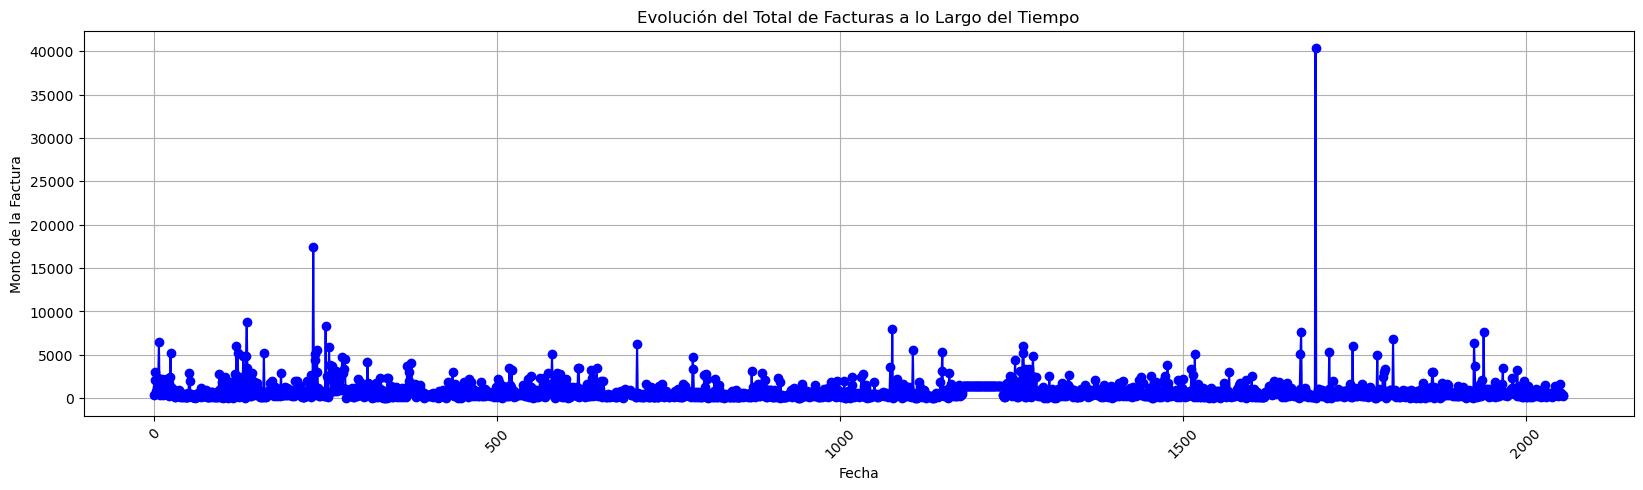

In [22]:
plt.figure(figsize=(20, 5))
plt.plot(df.index, df['TotalFactura'], marker='o', color='blue')
plt.title('Evolución del Total de Facturas a lo Largo del Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Monto de la Factura')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [23]:
Q1 = df['TotalFactura'].quantile(0.25)
Q3 = df['TotalFactura'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['TotalFactura'] < lower_bound) | (df['TotalFactura'] > upper_bound)]
num_outliers = len(outliers)

print(f"There are {num_outliers} outliers in TotalFactura.")

There are 138 outliers in TotalFactura.


Prueba de estacionalidad

## **Fase 3**: Preparacion de los Datos

 **Hotel Resort**

Agrupar las fechas iguales

In [28]:
df = df.groupby('Fecha').sum()

In [29]:
rango_completo = pd.date_range(
    start=df.index.min(),
    end=df.index.max(),
    freq='D'
)

In [30]:
df = df.reindex(rango_completo)

In [31]:
df['TotalFactura'] = df['TotalFactura'].fillna(0)

In [32]:
df = df.resample('W').sum()

In [33]:
Q1 = df['TotalFactura'].quantile(0.25)
Q3 = df['TotalFactura'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Detectar outliers
outliers = df[(df['TotalFactura'] < lower_bound) | (df['TotalFactura'] > upper_bound)]

# Seleccionar los outliers significativos
outliers_top4 = outliers.reindex(outliers['TotalFactura'].abs().sort_values(ascending=False).index[:3])

In [34]:
for i in range(len(outliers_top4)):
    idx = outliers_top4.index[i]
    # Opción 1: reemplazo por la media de los vecinos anteriores y posteriores
    prev_idx = df.index[df.index.get_loc(idx) - 1] if df.index.get_loc(idx) - 1 >= 0 else df.index[0]
    next_idx = df.index[df.index.get_loc(idx) + 1] if df.index.get_loc(idx) + 1 < len(df) else df.index[-1]

    prev_val = df['TotalFactura'].loc[prev_idx]
    next_val = df['TotalFactura'].loc[next_idx]
    suavizado = (prev_val + next_val) / 2

    df.at[idx, 'TotalFactura'] = suavizado

**Exploracion de Datos**

In [36]:
df.count()

TotalFactura    165
dtype: int64

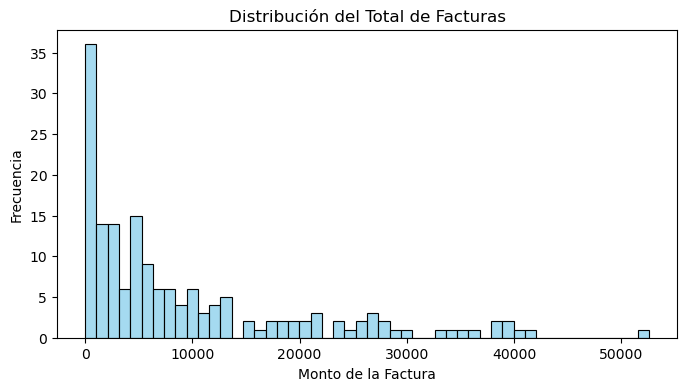

In [37]:
plt.figure(figsize=(8, 4))
sns.histplot(df['TotalFactura'], bins=50, color='skyblue')
plt.title('Distribución del Total de Facturas')
plt.xlabel('Monto de la Factura')
plt.ylabel('Frecuencia')
plt.show()

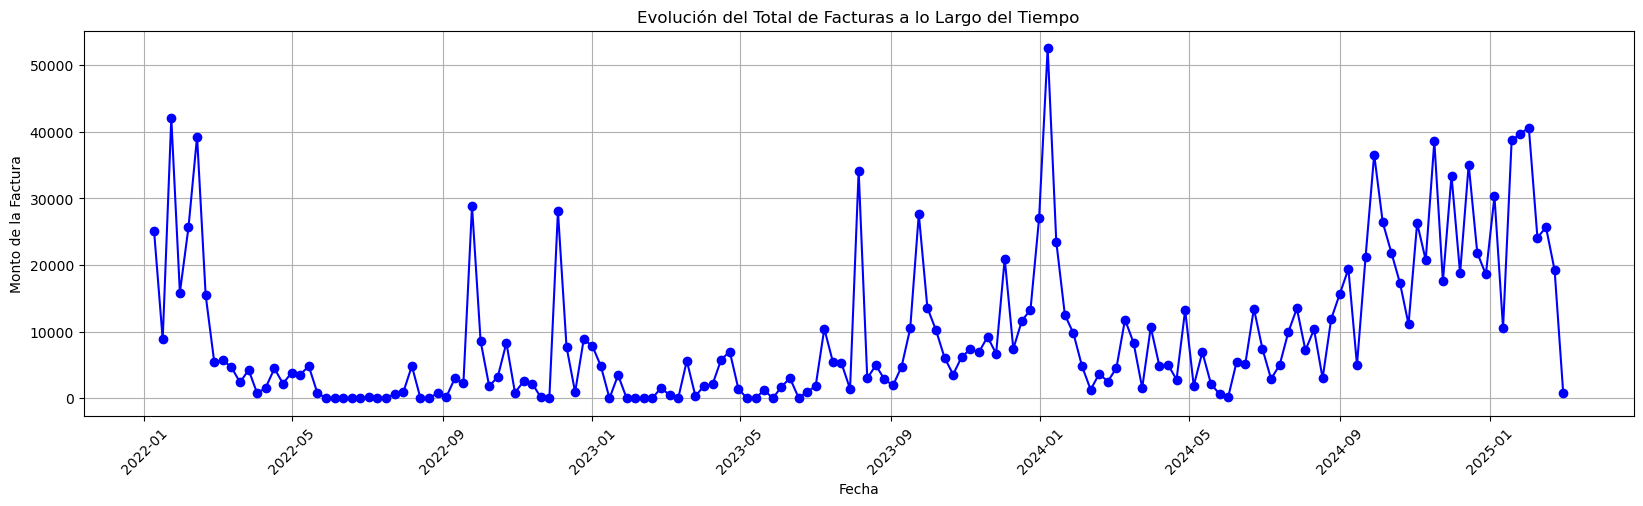

In [38]:
plt.figure(figsize=(20, 5))
plt.plot(df.index, df['TotalFactura'], marker='o', color='blue')
plt.title('Evolución del Total de Facturas a lo Largo del Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Monto de la Factura')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

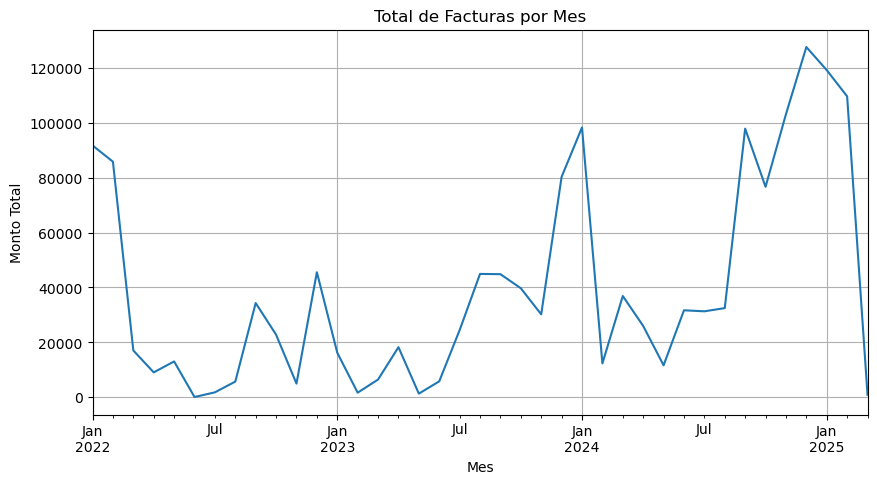

In [39]:
df.sort_index(inplace=True)
df['TotalFactura'].resample('ME').sum().plot(title='Total de Facturas por Mes', figsize=(10, 5))
plt.ylabel('Monto Total')
plt.xlabel('Mes')
plt.grid(True)
plt.show()

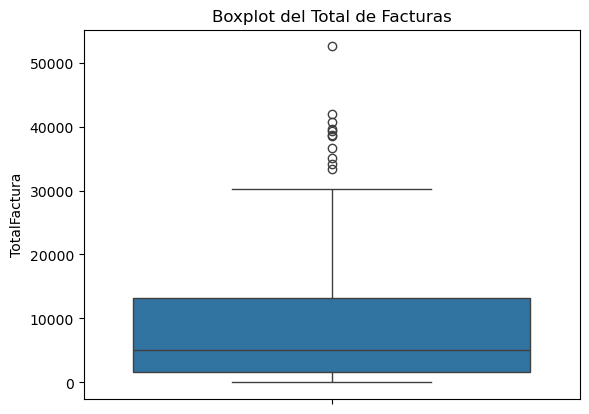

In [40]:
sns.boxplot(df['TotalFactura'])
plt.title('Boxplot del Total de Facturas')
plt.show()

Revizamos los outliers pero no se eliminara debido a la importancia de los mismos

In [42]:
Q1 = df['TotalFactura'].quantile(0.25)
Q3 = df['TotalFactura'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['TotalFactura'] < lower_bound) | (df['TotalFactura'] > upper_bound)]
num_outliers = len(outliers)

print(f"There are {num_outliers} outliers in TotalFactura.")

There are 11 outliers in TotalFactura.


Revision de autocorrelacion

**Transformaciones Y Division de datos**

Division


escalado

In [47]:
df = df.sort_index()
data = df[['TotalFactura']].values

# Escalar los datos
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

In [48]:
def crear_secuencias(data, n_pasos):
    X, y = [], []
    for i in range(n_pasos, len(data)):
        X.append(data[i - n_pasos:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

n_pasos = 12  # 12 semanas (~3 meses de contexto)
X, y = crear_secuencias(data_scaled, n_pasos)

# Ajustar dimensiones [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# División en entrenamiento y prueba (80/20)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

## **Fase 4**: Modelamiento

 **Manual**

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

modeloM = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(n_pasos, 1)),
    Dropout(0.3),
    LSTM(64, activation='tanh', return_sequences=True),
    Dropout(0.3),
    LSTM(32, activation='tanh', return_sequences=False),
    Dropout(0.3),
    Dense(1)
])

modeloM.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

F:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [52]:
modeloM.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.2, verbose=1)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - loss: 0.0371 - val_loss: 0.0071
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0258 - val_loss: 0.0095
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0249 - val_loss: 0.0093
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0231 - val_loss: 0.0079
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0265 - val_loss: 0.0079
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0185 - val_loss: 0.0081
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0240 - val_loss: 0.0100
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0257 - val_loss: 0.0124
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0209 - val_loss: 0.0090
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0251 - val_loss: 0.0080
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0188 - val_loss: 0.0080
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0185 - val_l

 **Automatico**

In [54]:
def build_model(hp):
    model = Sequential()
    model.add(
        LSTM(
            units=hp.Int('units_lstm_1', min_value=32, max_value=256, step=32),
            activation='tanh',
            return_sequences=True,
            input_shape=(n_pasos, 1)
        )
    )
    model.add(Dropout(hp.Float('dropout_1', 0.1, 0.5, step=0.1)))

    model.add(
        LSTM(
            units=hp.Int('units_lstm_2', min_value=32, max_value=128, step=32),
            activation='tanh',
            return_sequences=True
        )
    )
    model.add(Dropout(hp.Float('dropout_2', 0.1, 0.5, step=0.1)))

    model.add(
        LSTM(
            units=hp.Int('units_lstm_3', min_value=16, max_value=64, step=16),
            activation='tanh',
            return_sequences=False
        )
    )
    model.add(Dropout(hp.Float('dropout_3', 0.1, 0.5, step=0.1)))

    model.add(Dense(1))

    model.compile(
        optimizer=Adam(
            learning_rate=hp.Choice('learning_rate', values=[0.001, 0.0005, 0.0001])
        ),
        loss='mse'
    )

    return model

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='lstm_tuning',
    project_name='sales_forecast_lstm'
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[early_stop], verbose=1)

Reloading Tuner from lstm_tuning\sales_forecast_lstm\tuner0.json


## **Fase 5**: Evaluacion

In [56]:
y_predM = modeloM.predict(X_test)

# Inversión del escalado
y_pred_invM = scaler.inverse_transform(y_predM)
y_test_invM = scaler.inverse_transform(y_test.reshape(-1, 1))

# Cálculo de métricas
rmse = np.sqrt(mean_squared_error(y_test_invM, y_pred_invM))
mae = mean_absolute_error(y_test_invM, y_pred_invM)
mape = np.mean(np.abs((y_test_invM - y_pred_invM) / y_test_invM)) * 100

print(f"LSTM - RMSE: {rmse:.2f}")
print(f"LSTM - MAE: {mae:.2f}")
print(f"LSTM - MAPE: {mape:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step
LSTM - RMSE: 13331.76
LSTM - MAE: 10593.84
LSTM - MAPE: 104.84%


 **Hotel Resort**

In [58]:
model = tuner.get_best_models(num_models=1)[0]

y_pred = model.predict(X_test)

# Inversión del escalado
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Cálculo de métricas
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100

print(f"LSTM - RMSE: {rmse:.2f}")
print(f"LSTM - MAE: {mae:.2f}")
print(f"LSTM - MAPE: {mape:.2f}%")

F:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
F:\anaconda\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
LSTM - RMSE: 18137.89
LSTM - MAE: 15362.87
LSTM - MAPE: 90.79%


## **Fase 6**: Despliegue

**Hotel Resort**

F:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
F:\anaconda\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


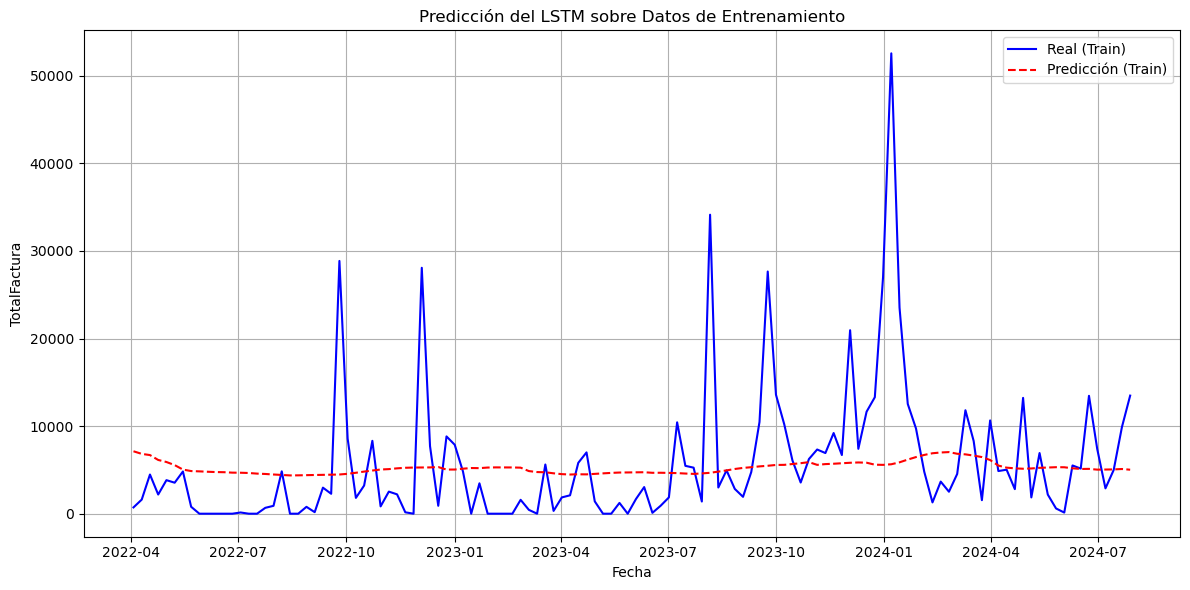

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
from tensorflow.keras.models import Sequential 

model = tuner.get_best_models(num_models=1)[0] 
y_train_pred = model.predict(X_train)

y_train_pred_inv = scaler.inverse_transform(y_train_pred)
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1)) 

fechas_entrenamiento = df.index[n_pasos:n_pasos+len(y_train)] 

plt.figure(figsize=(12, 6))

plt.plot(fechas_entrenamiento, y_train_inv, label='Real (Train)', color='blue')

plt.plot(fechas_entrenamiento, y_train_pred_inv, label='Predicción (Train)', color='red', linestyle='--')
plt.title('Predicción del LSTM sobre Datos de Entrenamiento')
plt.xlabel('Fecha')
plt.ylabel('TotalFactura')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  


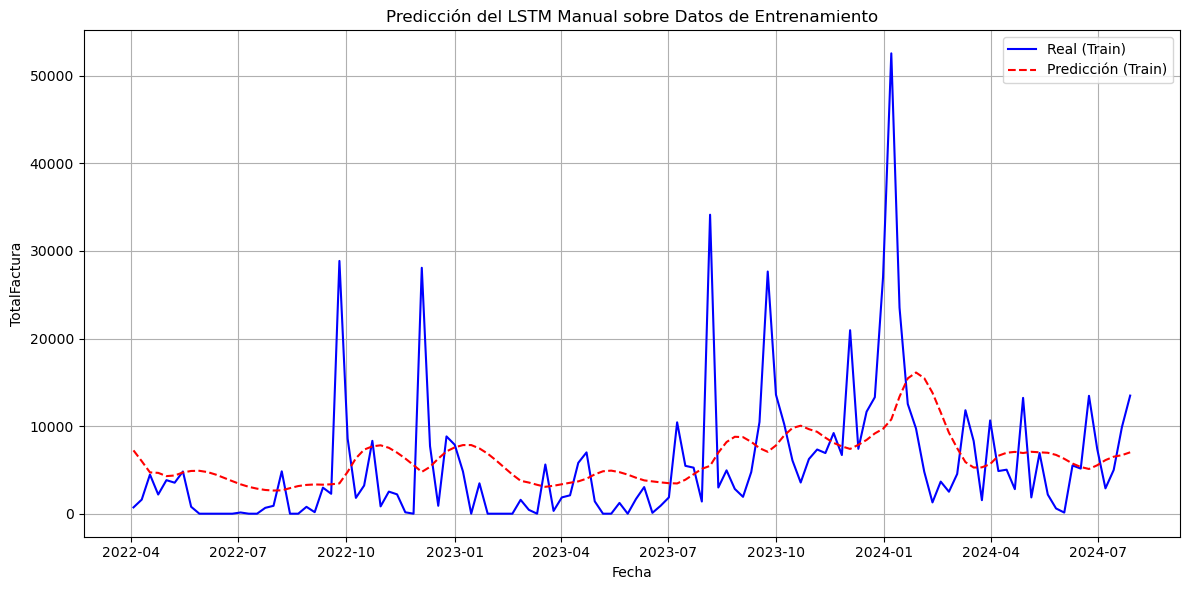

In [62]:
y_train_predM = modeloM.predict(X_train)

y_train_pred_invM = scaler.inverse_transform(y_train_predM)
y_train_invM = scaler.inverse_transform(y_train.reshape(-1, 1)) 

fechas_entrenamiento = df.index[n_pasos:n_pasos+len(y_train)] 

plt.figure(figsize=(12, 6))

plt.plot(fechas_entrenamiento, y_train_invM, label='Real (Train)', color='blue')

plt.plot(fechas_entrenamiento, y_train_pred_invM, label='Predicción (Train)', color='red', linestyle='--')
plt.title('Predicción del LSTM Manual sobre Datos de Entrenamiento')
plt.xlabel('Fecha')
plt.ylabel('TotalFactura')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

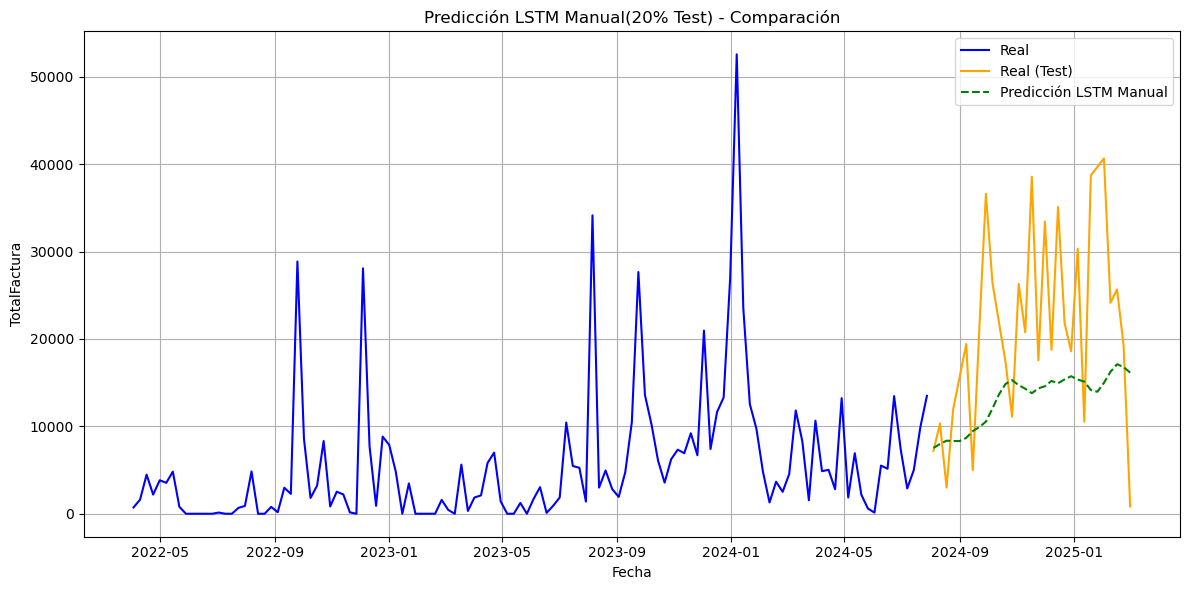

In [63]:
# Manual
fechas_test = df.index[n_pasos + train_size:]

plt.figure(figsize=(12, 6))
plt.plot(fechas_entrenamiento, y_train_invM, label='Real', color='blue')
plt.plot(fechas_test, y_test_invM, label='Real (Test)', color='orange')
plt.plot(fechas_test, y_pred_invM, label='Predicción LSTM Manual', linestyle='--', color='green')
plt.title("Predicción LSTM Manual(20% Test) - Comparación")
plt.xlabel("Fecha")
plt.ylabel("TotalFactura")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


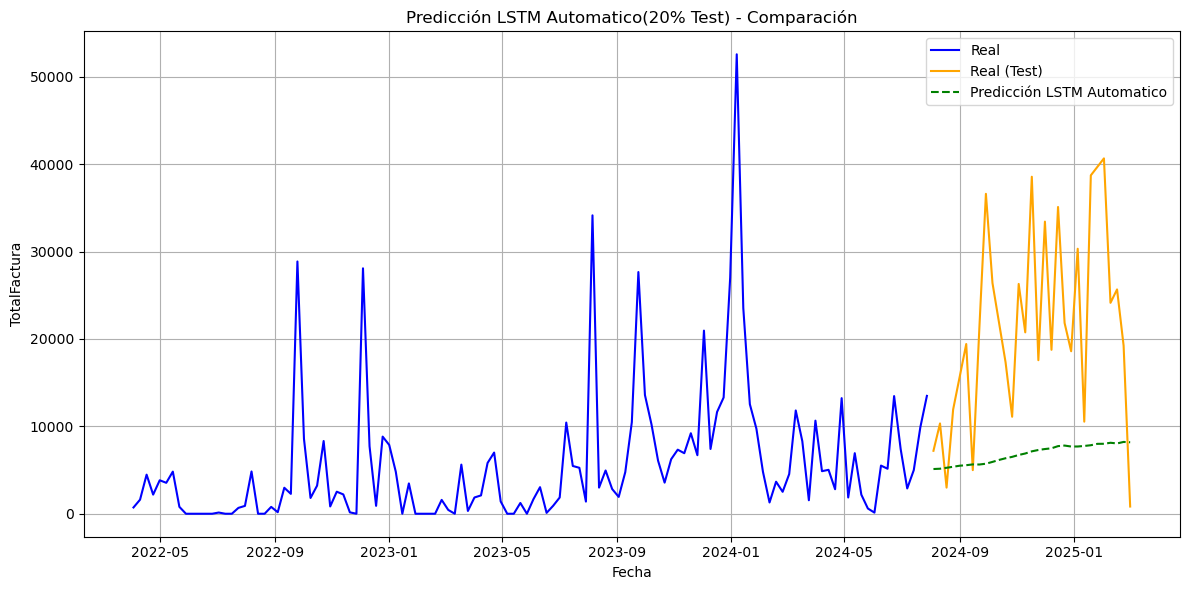

In [64]:
# AUTOMATICO
fechas_test = df.index[n_pasos + train_size:]

plt.figure(figsize=(12, 6))
plt.plot(fechas_entrenamiento, y_train_inv, label='Real', color='blue')
plt.plot(fechas_test, y_test_inv, label='Real (Test)', color='orange')
plt.plot(fechas_test, y_pred_inv, label='Predicción LSTM Automatico', linestyle='--', color='green')
plt.title("Predicción LSTM Automatico(20% Test) - Comparación")
plt.xlabel("Fecha")
plt.ylabel("TotalFactura")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [65]:
ultimos_datos = data_scaled[-n_pasos:].reshape(1, n_pasos, 1)

In [66]:
ultimos_datosM = data_scaled[-n_pasos:].reshape(1, n_pasos, 1)

In [67]:
predicciones_futurasM = []

for _ in range(52):
    pred = modeloM.predict(ultimos_datosM)[0][0]         # predicción única (escalar)
    predicciones_futurasM.append(pred)                 # guardar
    nueva_entradaM = np.append(ultimos_datosM[0, 1:, 0], pred)  # eliminar el primer paso y agregar el nuevo
    ultimos_datosM = nueva_entradaM.reshape(1, n_pasos, 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

In [68]:
predicciones_futuras = []

for _ in range(52):
    pred = model.predict(ultimos_datos)[0][0]         # predicción única (escalar)
    predicciones_futuras.append(pred)                 # guardar
    nueva_entrada = np.append(ultimos_datos[0, 1:, 0], pred)  # eliminar el primer paso y agregar el nuevo
    ultimos_datos = nueva_entrada.reshape(1, n_pasos, 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

In [69]:
# Invertir el escalado
predicciones_futuras_inv = scaler.inverse_transform(np.array(predicciones_futuras).reshape(-1, 1))

# Crear fechas futuras (semanales)
ultima_fecha = df.index[-1]
fechas_futuras = pd.date_range(start=ultima_fecha + pd.Timedelta(weeks=1), periods=52, freq='W')

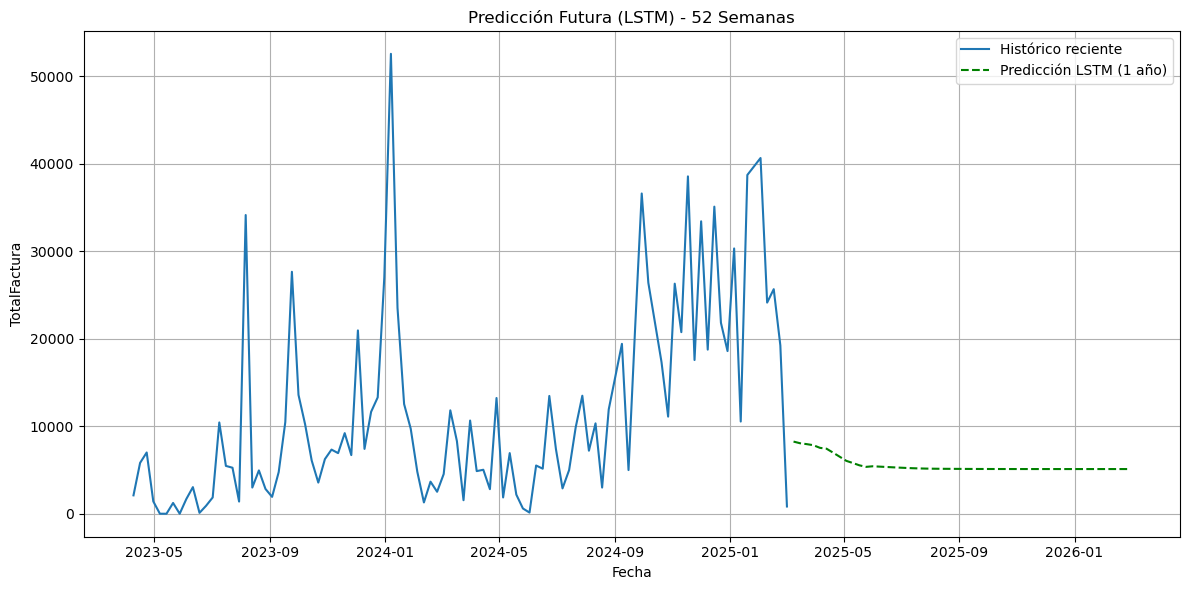

In [70]:
plt.figure(figsize=(12, 6))
plt.plot(df.index[-100:], df['TotalFactura'].values[-100:], label='Histórico reciente')
plt.plot(fechas_futuras, predicciones_futuras_inv, label='Predicción LSTM (1 año)', linestyle='--', color='green')
plt.title('Predicción Futura (LSTM) - 52 Semanas')
plt.xlabel('Fecha')
plt.ylabel('TotalFactura')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [71]:
# Invertir el escalado
predicciones_futuras_invM = scaler.inverse_transform(np.array(predicciones_futurasM).reshape(-1, 1))

# Crear fechas futuras (semanales)
ultima_fecha = df.index[-1]
fechas_futuras = pd.date_range(start=ultima_fecha + pd.Timedelta(weeks=1), periods=52, freq='W')

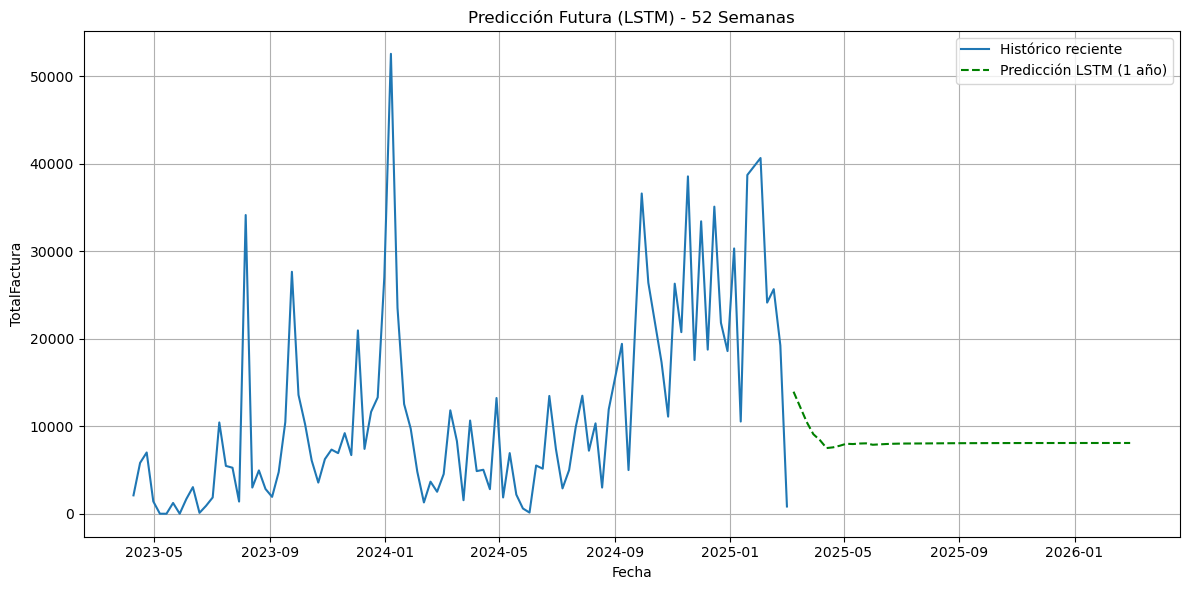

In [72]:
plt.figure(figsize=(12, 6))
plt.plot(df.index[-100:], df['TotalFactura'].values[-100:], label='Histórico reciente')
plt.plot(fechas_futuras, predicciones_futuras_invM, label='Predicción LSTM (1 año)', linestyle='--', color='green')
plt.title('Predicción Futura (LSTM) - 52 Semanas')
plt.xlabel('Fecha')
plt.ylabel('TotalFactura')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig(r"../Graficos/prediccion_LSTM.png", dpi=300)

plt.show()

In [73]:
import pandas as pd

# Crear DataFrame con fechas futuras y predicciones
df_futuro_lstm = pd.DataFrame({
    'Fecha': fechas_futuras,
    'Prediccion_LSTM': predicciones_futuras_inv.flatten()
})

# Guardar en CSV
df_futuro_lstm.to_csv(r"../Documentos/prediccion_lstm.csv", index=False)

In [74]:
df_futuro_lstm

,Fecha,Prediccion_LSTM
0,2025-03-09,8245.175781
1,2025-03-16,8052.612793
2,2025-03-23,7953.020996
3,2025-03-30,7832.094238
4,2025-04-06,7530.215820
5,2025-04-13,7429.294922
6,2025-04-20,6976.154297
7,2025-04-27,6511.172852
8,2025-05-04,6042.302734
9,2025-05-11,5791.060059
